In [13]:
from pyspark.sql import SparkSession

# Start Spark session
spark = SparkSession.builder.appName("CS131 HW Data Analysis").getOrCreate()

# Define the path to your data in GCS
gcs_path = "gs://dataproc-staging-us-central1-156990865139-iitllk4z/data/cs131_hw data.csv"

# Read the CSV file
df = spark.read.csv(gcs_path, header=True, inferSchema=True)

# Show the first few rows to check it loaded correctly
df.show()

+-----------+-----------+-----------+-----------+-----------+-----------+
|       Slow|        _c1|     Medium|        _c3|       Fast|        _c5|
+-----------+-----------+-----------+-----------+-----------+-----------+
|     Strain|     Stress|     Strain|     Stress|     Strain|     Stress|
|          0|          0|          0|          0|          0|          0|
| 0.00915646|0.010936813|0.008717747|0.024057692|0.017179956|  0.0393663|
| 0.00380472|0.026244506|0.041222876|0.054678571|0.047299379|0.083107143|
|0.026598903|0.037177656|0.041665982|0.076548535|0.037457412|0.115914835|
|0.007227702|0.045927656|0.053202124|0.091857143|0.027806919|0.133410256|
| 0.02360147|0.048115385|0.087396748|0.098419414|0.064813328|0.144343407|
|0.011902567|0.052489927|0.091506313|0.107164835|0.070880417|0.153093407|
| 0.02964265|0.059052198|0.046021905|0.120289377| 0.10429467|0.170588828|
|0.002593851|0.061236264|0.094411195|0.124660256|0.105845028|0.177151099|
| 0.00372824|0.065610806|0.064478643|0

In [4]:
import pandas as pd

# Load the original data
df = pd.read_csv("gs://dataproc-staging-us-central1-156990865139-iitllk4z/data/cs131_hw data.csv", skiprows=1)

# Define multipliers for different file sizes
multipliers = [1, 5, 10, 20, 40]  # e.g., 1x, 5x, ..., 40x the original size
base_rows = df.shape[0]

for i, m in enumerate(multipliers):
    df_big = pd.concat([df] * m, ignore_index=True)
    file_name = f"data_{m}x.csv"
    df_big.to_csv(file_name, index=False)
    print(f"Created {file_name} with {len(df_big)} rows")

Created data_1x.csv with 980 rows
Created data_5x.csv with 4900 rows
Created data_10x.csv with 9800 rows
Created data_20x.csv with 19600 rows
Created data_40x.csv with 39200 rows


In [6]:
!gsutil cp data_*.csv gs://dataproc-staging-us-central1-156990865139-iitllk4z/data/

Copying file://data_10x.csv [Content-Type=text/csv]...
Copying file://data_1x.csv [Content-Type=text/csv]...                           
Copying file://data_20x.csv [Content-Type=text/csv]...                          
Copying file://data_40x.csv [Content-Type=text/csv]...                          
- [4 files][  2.8 MiB/  2.8 MiB]                                                
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m cp ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Copying file://data_5x.csv [Content-Type=text/csv]...
- [5 files][  3.0 MiB/  3.0 MiB]                                                
Operation completed over 5 objects/3.0 MiB.                                      


In [14]:
from pyspark.sql.functions import col

# Define the second header row (which we want to filter out)
header_row = ["Strain", "Stress", "Strain", "Stress", "Strain", "Stress"]

# Filter out the second header row
df_filtered = df.filter(~(
    (col("Slow") == header_row[0]) & 
    (col("_c1") == header_row[1]) & 
    (col("Medium") == header_row[2]) & 
    (col("_c3") == header_row[3]) & 
    (col("Fast") == header_row[4]) & 
    (col("_c5") == header_row[5])
))

# Cast columns to double type (for numerical operations)
df_casted = df_filtered.select([col(c).cast("double").alias(c) for c in df_filtered.columns])

# Calculate the average stress values for each column
result = df_casted.selectExpr(
    "avg(_c1) as Slow_Stress_Avg",
    "avg(_c3) as Medium_Stress_Avg",
    "avg(_c5) as Fast_Stress_Avg"
)

# Show the results
result.show()


+------------------+------------------+-------------------+
|   Slow_Stress_Avg| Medium_Stress_Avg|    Fast_Stress_Avg|
+------------------+------------------+-------------------+
|0.5213740631435875|0.6387648884512837|0.45058724521709387|
+------------------+------------------+-------------------+



In [22]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import time

# Start Spark session
spark = SparkSession.builder.appName("CS131 HW Data Analysis").getOrCreate()

# List of file paths for the 5 different sizes
file_paths = [
    "gs://dataproc-staging-us-central1-156990865139-iitllk4z/data/data_1x.csv",
    "gs://dataproc-staging-us-central1-156990865139-iitllk4z/data/data_5x.csv",
    "gs://dataproc-staging-us-central1-156990865139-iitllk4z/data/data_10x.csv",
    "gs://dataproc-staging-us-central1-156990865139-iitllk4z/data/data_20x.csv",
    "gs://dataproc-staging-us-central1-156990865139-iitllk4z/data/data_40x.csv"
]

# Read the first file from the list
df = spark.read.csv(file_paths[0], header=True, inferSchema=True)

# Show the first 10 rows
df.show(10)




+-----------+-----------+-----------+-----------+-----------+-----------+
|     Strain|     Stress|   Strain.1|   Stress.1|   Strain.2|   Stress.2|
+-----------+-----------+-----------+-----------+-----------+-----------+
|        0.0|        0.0|        0.0|        0.0|        0.0|        0.0|
| 0.00915646|0.010936813|0.008717747|0.024057692|0.017179956|  0.0393663|
| 0.00380472|0.026244506|0.041222876|0.054678571|0.047299379|0.083107143|
|0.026598903|0.037177656|0.041665982|0.076548535|0.037457412|0.115914835|
|0.007227702|0.045927656|0.053202124|0.091857143|0.027806919|0.133410256|
| 0.02360147|0.048115385|0.087396748|0.098419414|0.064813328|0.144343407|
|0.011902567|0.052489927|0.091506313|0.107164835|0.070880417|0.153093407|
| 0.02964265|0.059052198|0.046021905|0.120289377| 0.10429467|0.170588828|
|0.002593851|0.061236264|0.094411195|0.124660256|0.105845028|0.177151099|
| 0.00372824|0.065610806|0.064478643|0.133410256|0.115280578|0.185901099|
+-----------+-----------+-----------+-

In [44]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg
import time

# Start Spark session
spark = SparkSession.builder.appName("CS131 HW Data Analysis").getOrCreate()

# List of file paths for the 5 different sizes
file_paths = [
    "gs://dataproc-staging-us-central1-156990865139-iitllk4z/data/data_1x.csv",
    "gs://dataproc-staging-us-central1-156990865139-iitllk4z/data/data_5x.csv",
    "gs://dataproc-staging-us-central1-156990865139-iitllk4z/data/data_10x.csv",
    "gs://dataproc-staging-us-central1-156990865139-iitllk4z/data/data_20x.csv",
    "gs://dataproc-staging-us-central1-156990865139-iitllk4z/data/data_40x.csv"
]

def process_file(path):
    # Start the timer
    start_time = time.time()
    
    # Read the CSV file (no need to filter out the second header row)
    df = spark.read.csv(path, header=True, inferSchema=True)

    # Print the schema of the DataFrame to check the data types
    print(f"Schema of {path}:")
    df.printSchema()
    
    # Rename columns with problematic names (e.g., Strain.1 to Strain_1)
    df_renamed = df.withColumnRenamed("Strain.1", "Strain_1") \
                   .withColumnRenamed("Stress.1", "Stress_1") \
                   .withColumnRenamed("Strain.2", "Strain_2") \
                   .withColumnRenamed("Stress.2", "Stress_2")

    # Select only the necessary columns with 'Strain' or 'Stress'
    strain_stress_columns = [c for c in df_renamed.columns if 'Strain' in c or 'Stress' in c]
    
    # Calculate the average values for each column without casting (columns are already double type)
    result = df_renamed.agg(
        avg('Strain').alias('Strain_Avg'),
        avg('Stress').alias('Stress_Avg'),
        avg('Strain_1').alias('Strain1_Avg'),
        avg('Stress_1').alias('Stress1_Avg'),
        avg('Strain_2').alias('Strain2_Avg'),
        avg('Stress_2').alias('Stress2_Avg')
    )

    # Show the results
    result.show()

    # End the timer and return the time taken
    end_time = time.time()
    return end_time - start_time


# Run the process for each file and record the runtimes
runtimes = []
for file_path in file_paths:
    runtime = process_file(file_path)
    print(f"Processing {file_path} took {runtime} seconds")
    runtimes.append((file_path.split('/')[-1], runtime))

# Output the runtimes
for file_name, runtime in runtimes:
    print(f"{file_name}: {runtime} seconds")


Schema of gs://dataproc-staging-us-central1-156990865139-iitllk4z/data/data_1x.csv:
root
 |-- Strain: double (nullable = true)
 |-- Stress: double (nullable = true)
 |-- Strain.1: double (nullable = true)
 |-- Stress.1: double (nullable = true)
 |-- Strain.2: double (nullable = true)
 |-- Stress.2: double (nullable = true)

+-------------------+------------------+------------------+------------------+------------------+-------------------+
|         Strain_Avg|        Stress_Avg|       Strain1_Avg|       Stress1_Avg|       Strain2_Avg|        Stress2_Avg|
+-------------------+------------------+------------------+------------------+------------------+-------------------+
|0.48883739910085416|0.5213740631435875|0.6738233868119669|0.6387648884512837|0.5114470953333332|0.45058724521709387|
+-------------------+------------------+------------------+------------------+------------------+-------------------+

Processing gs://dataproc-staging-us-central1-156990865139-iitllk4z/data/data_1x.csv

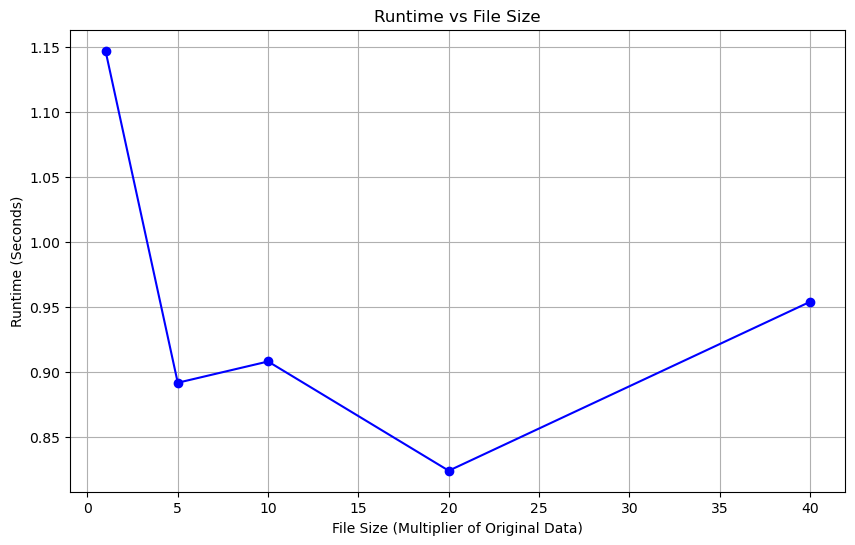

In [45]:
import matplotlib.pyplot as plt

# File sizes corresponding to the above file paths (in terms of multipliers)
file_sizes = [1, 5, 10, 20, 40]

# Extract runtimes from the results
runtimes = [runtime for _, runtime in runtimes]

# Plotting the runtime vs file size
plt.figure(figsize=(10,6))
plt.plot(file_sizes, runtimes, marker='o', linestyle='-', color='b')
plt.title("Runtime vs File Size")
plt.xlabel("File Size (Multiplier of Original Data)")
plt.ylabel("Runtime (Seconds)")
plt.grid(True)
plt.show()
